In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("Library Versions:")
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('tensorflow:',tf.__version__)
print('tensorflow probability:', tfp.__version__)

2023-11-15 14:13:15.943984: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 14:13:16.020943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:13:17.812220: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Library Versions:
numpy: 1.24.3
pandas: 1.5.3
tensorflow: 2.13.0
tensorflow probability: 0.21.0


In [2]:
from art.attacks.evasion import AutoAttack, SquareAttack

In [3]:
n_epochs = 200
verbose_option = True

# Classification for Ship Detection


Load Ship Detection Dataset

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT_PATH = "shipsnet"
LR = 1e-3
BATCH_SIZE=1000

def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(ROOT_PATH,
                            labels = 'inferred',
                            label_mode = 'categorical',
                            class_names = None,
                            color_mode = "rgb",
                            batch_size = BATCH_SIZE,
                            image_size = (80, 80),
                            shuffle = True,
                            seed = 42,
                            subset="both",
                            validation_split = 0.2,
)

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


2023-11-15 14:13:24.394058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1a:00.0, compute capability: 8.9


Using Tensoflow, perform  non-linear binary classification model for the classification dataset.

In [5]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

model = keras.Model(inputs=inputs, outputs=p)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

In [6]:
model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200


2023-11-15 14:13:29.742739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-15 14:13:29.752634: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f337c0398d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-15 14:13:29.752669: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-11-15 14:13:29.760646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-15 14:13:30.029218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-15 14:13:30.395142: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

4/4 [==============================] - 6s 22ms/step - loss: 2.5416 - categorical_accuracy: 0.6906 - categorical_crossentropy: 2.5416
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - loss: 1.3287 - categorical_accuracy: 0.6034 - categorical_crossentropy: 1.3287
Epoch 3/200
4/4 [==============================] - 0s 19ms/step - loss: 0.6080 - categorical_accuracy: 0.6022 - categorical_crossentropy: 0.6080
Epoch 4/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5792 - categorical_accuracy: 0.7591 - categorical_crossentropy: 0.5792
Epoch 5/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5010 - categorical_accuracy: 0.7616 - categorical_crossentropy: 0.5010
Epoch 6/200
4/4 [==============================] - 0s 20ms/step - loss: 0.4629 - categorical_accuracy: 0.8147 - categorical_crossentropy: 0.4629
Epoch 7/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4381 - categorical_accuracy: 0.8053 - categorical_crossentropy: 0.43

4/4 [==============================] - 0s 19ms/step - loss: 0.1743 - categorical_accuracy: 0.9312 - categorical_crossentropy: 0.1743
Epoch 114/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1712 - categorical_accuracy: 0.9337 - categorical_crossentropy: 0.1712
Epoch 115/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1684 - categorical_accuracy: 0.9337 - categorical_crossentropy: 0.1684
Epoch 116/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1664 - categorical_accuracy: 0.9347 - categorical_crossentropy: 0.1664
Epoch 117/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1654 - categorical_accuracy: 0.9337 - categorical_crossentropy: 0.1654
Epoch 118/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1648 - categorical_accuracy: 0.9347 - categorical_crossentropy: 0.1648
Epoch 119/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1644 - categorical_accuracy: 0.9341 - categorical_crosse

Evaluate the classification model on the test data

In [7]:
model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 1s 807ms/step - loss: 0.2177 - categorical_accuracy: 0.9225 - categorical_crossentropy: 0.2177


[0.21771898865699768, 0.9225000143051147, 0.21771898865699768]

In [8]:
examples, labels = list(test_dataset.as_numpy_iterator())[0]

In [9]:
model(np.reshape(examples[5],[1,80,80,3])).numpy()[0,0]

1.5787989

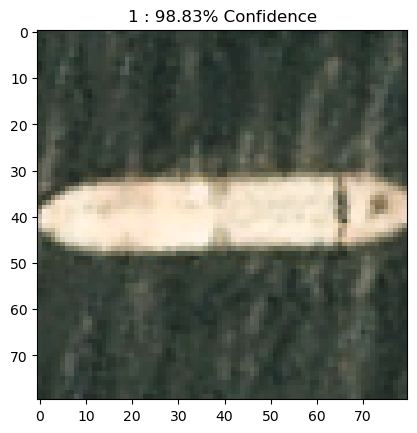

In [10]:
plt.figure()
plt.imshow(examples[5])
confidence = tf.nn.softmax(model(np.reshape(examples[5],[1,80,80,3])).numpy())[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

## AutoAttack

In [11]:
from art.estimators.classification import TensorFlowV2Classifier
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    nb_classes=2,
    input_shape=(80, 80, 3),
    clip_values=(0, 1),
)
auto = AutoAttack(estimator=classifier, eps=0.04, norm='inf', batch_size=1)
adv_ex = auto.generate(x=np.reshape(examples[5],[1,80,80,3]))

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

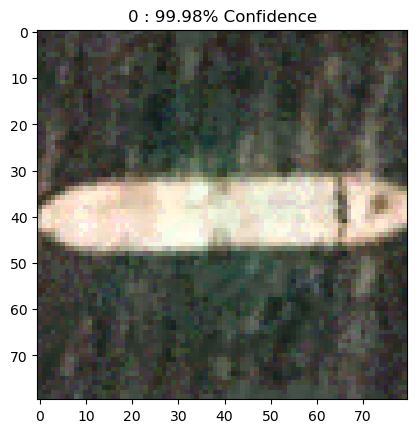

In [12]:
plt.figure()
adv_example = adv_ex 
plt.imshow(np.clip(adv_example[0],0,255))
confidence = tf.nn.softmax(model(np.reshape(adv_example,[1,80,80,3]))).numpy()[0,1] 
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

## Auto Attack vs. Stochastic Network Defense

In [13]:
inputs = layers.Input(shape=(80,80,3))
noise = layers.GaussianNoise(stddev=1)(inputs)
flat = layers.Flatten()(noise)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

sto_model = keras.Model(inputs=inputs, outputs=p)

sto_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

In [15]:
sto_model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
4/4 [==============================] - 2s 19ms/step - loss: 1.5450 - categorical_accuracy: 0.6366 - categorical_crossentropy: 1.5450
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - loss: 0.7859 - categorical_accuracy: 0.7566 - categorical_crossentropy: 0.7859
Epoch 3/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5948 - categorical_accuracy: 0.6963 - categorical_crossentropy: 0.5948
Epoch 4/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5539 - categorical_accuracy: 0.7538 - categorical_crossentropy: 0.5539
Epoch 5/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5288 - categorical_accuracy: 0.7669 - categorical_crossentropy: 0.5288
Epoch 6/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4727 - categorical_accuracy: 0.8091 - categorical_crossentropy: 0.4727
Epoch 7/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4410 - categorical_accuracy: 0.8075 - categorical_crosse

4/4 [==============================] - 0s 19ms/step - loss: 0.2161 - categorical_accuracy: 0.9122 - categorical_crossentropy: 0.2161
Epoch 114/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2299 - categorical_accuracy: 0.9091 - categorical_crossentropy: 0.2299
Epoch 115/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2312 - categorical_accuracy: 0.9031 - categorical_crossentropy: 0.2312
Epoch 116/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2266 - categorical_accuracy: 0.9116 - categorical_crossentropy: 0.2266
Epoch 117/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2299 - categorical_accuracy: 0.9081 - categorical_crossentropy: 0.2299
Epoch 118/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2209 - categorical_accuracy: 0.9109 - categorical_crossentropy: 0.2209
Epoch 119/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2140 - categorical_accuracy: 0.9134 - categorical_crosse

In [16]:
from art.estimators.classification import TensorFlowV2Classifier
sto_classifier = TensorFlowV2Classifier(
    model=sto_model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    nb_classes=2,
    input_shape=(80, 80, 3),
    clip_values=(0, 1),
)
auto = AutoAttack(estimator=sto_classifier, eps=0.04, norm='inf', batch_size=1)
adv_ex2 = auto.generate(x=np.reshape(examples[5],[1,80,80,3]))

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

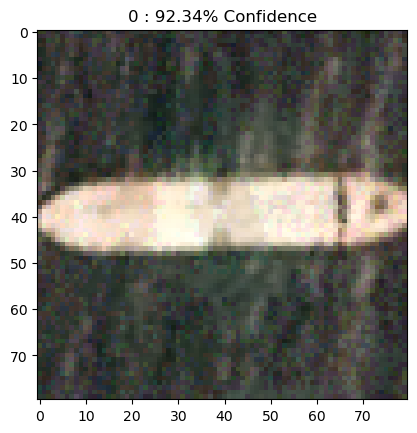

In [18]:
plt.figure()
adv_example = adv_ex2 
plt.imshow(np.clip(adv_example[0],0,255))
confidence = tf.nn.softmax(model(np.reshape(adv_example,[1,80,80,3]))).numpy()[0,1] 
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

# Square Attack

In [19]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

model = keras.Model(inputs=inputs, outputs=p)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
4/4 [==============================] - 2s 19ms/step - loss: 0.8352 - categorical_accuracy: 0.4459 - categorical_crossentropy: 0.8352
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - loss: 1.1276 - categorical_accuracy: 0.6034 - categorical_crossentropy: 1.1276
Epoch 3/200
4/4 [==============================] - 0s 19ms/step - loss: 0.8322 - categorical_accuracy: 0.5550 - categorical_crossentropy: 0.8322
Epoch 4/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5949 - categorical_accuracy: 0.7634 - categorical_crossentropy: 0.5949
Epoch 5/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5537 - categorical_accuracy: 0.7819 - categorical_crossentropy: 0.5537
Epoch 6/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4795 - categorical_accuracy: 0.7869 - categorical_crossentropy: 0.4795
Epoch 7/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4659 - categorical_accuracy: 0.8059 - categorical_crosse

4/4 [==============================] - 0s 19ms/step - loss: 0.2071 - categorical_accuracy: 0.9162 - categorical_crossentropy: 0.2071
Epoch 114/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2070 - categorical_accuracy: 0.9153 - categorical_crossentropy: 0.2070
Epoch 115/200
4/4 [==============================] - 0s 19ms/step - loss: 0.2134 - categorical_accuracy: 0.9150 - categorical_crossentropy: 0.2134
Epoch 116/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1953 - categorical_accuracy: 0.9216 - categorical_crossentropy: 0.1953
Epoch 117/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1840 - categorical_accuracy: 0.9262 - categorical_crossentropy: 0.1840
Epoch 118/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1788 - categorical_accuracy: 0.9278 - categorical_crossentropy: 0.1788
Epoch 119/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1763 - categorical_accuracy: 0.9328 - categorical_crosse

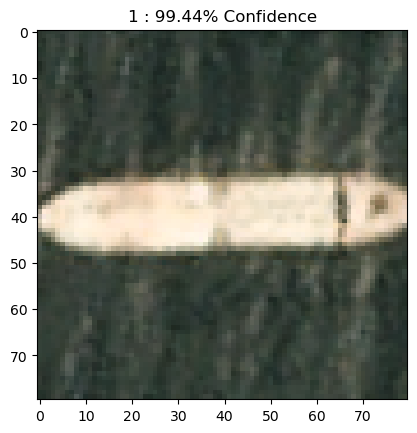

In [20]:
plt.figure()
plt.imshow(examples[5])
confidence = tf.nn.softmax(model(np.reshape(examples[5],[1,80,80,3])).numpy())[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [21]:
from art.estimators.classification import TensorFlowV2Classifier
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    nb_classes=2,
    input_shape=(80, 80, 3),
    clip_values=(0, 1),
)
square = SquareAttack(estimator=classifier, eps=15, norm=2, batch_size=1)
adv_ex = square.generate(x=np.reshape(examples[5],[1,80,80,3]))

SquareAttack - restarts:   0%|          | 0/1 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

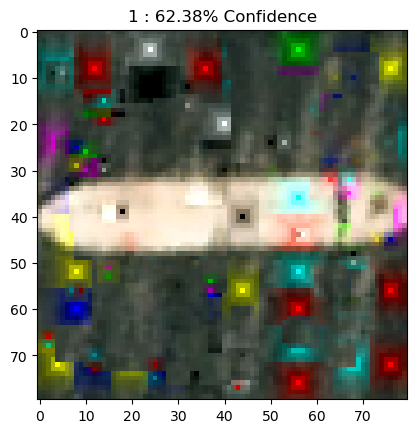

In [22]:
plt.figure()
adv_example = adv_ex 
plt.imshow(np.clip(adv_example[0],0,255))
confidence = tf.nn.softmax(model(np.reshape(adv_example[0],[1,80,80,3]))).numpy()[0,1] 
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [23]:
inputs = layers.Input(shape=(80,80,3))
noise = layers.GaussianNoise(stddev=2)(inputs)
flat = layers.Flatten()(noise)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

sto_model2 = keras.Model(inputs=inputs, outputs=p)

sto_model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)
sto_model2.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
4/4 [==============================] - 2s 19ms/step - loss: 0.8060 - categorical_accuracy: 0.6850 - categorical_crossentropy: 0.8060
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5956 - categorical_accuracy: 0.7103 - categorical_crossentropy: 0.5956
Epoch 3/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5778 - categorical_accuracy: 0.7328 - categorical_crossentropy: 0.5778
Epoch 4/200
4/4 [==============================] - 0s 19ms/step - loss: 0.5293 - categorical_accuracy: 0.7638 - categorical_crossentropy: 0.5293
Epoch 5/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4859 - categorical_accuracy: 0.7881 - categorical_crossentropy: 0.4859
Epoch 6/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4798 - categorical_accuracy: 0.7887 - categorical_crossentropy: 0.4798
Epoch 7/200
4/4 [==============================] - 0s 19ms/step - loss: 0.4505 - categorical_accuracy: 0.8006 - categorical_crosse

4/4 [==============================] - 0s 19ms/step - loss: 0.3414 - categorical_accuracy: 0.8572 - categorical_crossentropy: 0.3414
Epoch 114/200
4/4 [==============================] - 0s 19ms/step - loss: 0.3326 - categorical_accuracy: 0.8550 - categorical_crossentropy: 0.3326
Epoch 115/200
4/4 [==============================] - 0s 19ms/step - loss: 0.3400 - categorical_accuracy: 0.8597 - categorical_crossentropy: 0.3400
Epoch 116/200
4/4 [==============================] - 0s 19ms/step - loss: 0.3241 - categorical_accuracy: 0.8653 - categorical_crossentropy: 0.3241
Epoch 117/200
4/4 [==============================] - 0s 19ms/step - loss: 0.3458 - categorical_accuracy: 0.8481 - categorical_crossentropy: 0.3458
Epoch 118/200
4/4 [==============================] - 0s 19ms/step - loss: 0.3515 - categorical_accuracy: 0.8525 - categorical_crossentropy: 0.3515
Epoch 119/200
4/4 [==============================] - 0s 19ms/step - loss: 0.3277 - categorical_accuracy: 0.8625 - categorical_crosse

In [24]:
def_classifier = TensorFlowV2Classifier(
    model=sto_model2,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    nb_classes=2,
    input_shape=(80, 80, 3),
    clip_values=(0, 1),
)
square = SquareAttack(estimator=classifier, eps=15, norm=2, batch_size=1)
adv_ex = square.generate(x=np.reshape(examples[:6],[6,80,80,3]))

SquareAttack - restarts:   0%|          | 0/1 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

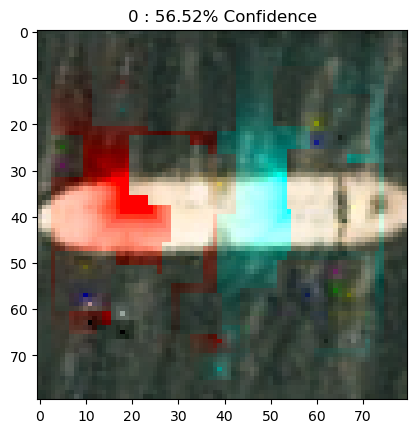

In [25]:
plt.figure()
adv_example = adv_ex 

plt.imshow(np.clip(adv_example[5],0,255))
confidence = tf.nn.softmax(model(np.reshape(adv_example[5],[1,80,80,3]))).numpy()[0,1] 
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()